In [ ]:
# H-R Diagram from HST Image Algorithm
#
# 1st: Load images
#       - convert image to flux
# 2nd: Cosmic Ray Removal
#       - need to median-combine the three images
#         and that magically removes the cosmic rays
# 3rd: Locate bright sources
#       - mask to find coordinates of high fluxes
# 4th: Find Stars
#       - weird gaussian thing to see if they're circular enough
#       - get rid of not gaussian and also negative fluxes
# 5th: Catalog Stars
#       - numbered, list global coords, and flux sum
# 6th: Get their ABS Mag
#       - do math in catalog
# 7th: Combine Filter Catalogs
#
# 8th: Make HR Diagram
#       -
# 9th: Hope it works

In [5]:
## Load Image Data
#from astropy.io import fits

# Note: hardcoding filenames so I know exactly which variable I save an image to,
#       instead of creating a glob .fits multi-image array

#F336W Filter Images
#img1_336_file = 'ubai2505m_c0m_aligned.fits'
#with fits.open(img1_336_file) as hdul:
#    img1_336_head = hdul[0].header
#    img1_336_data = hdul[1].data

#img2_336_file = 'ubai2507m_c0m_aligned.fits'
#with fits.open(img2_336_file) as hdul:
#    img2_336_head = hdul[0].header
#    img2_336_data = hdul[1].data

#img3_336_file = 'ubai2508m_c0m_aligned.fits'
#with fits.open(img3_336_file) as hdul:
#    img3_336_head = hdul[0].header
#    img3_336_data = hdul[1].data

#F55W Filter Images
#img1_555_file = 'ubai2502m_c0m_aligned.fits'
#with fits.open(img1_555_file) as hdul:
#    img1_555_head = hdul[0].header
#    img1_555_data = hdul[1].data

#img2_555_file = 'ubai2503m_c0m_aligned.fits'
#with fits.open(img2_555_file) as hdul:
#    img2_555_head = hdul[0].header
#    img2_555_data = hdul[1].data

#img3_555_file = 'ubai2504m_c0m_aligned.fits'
#with fits.open(img3_555_file) as hdul:
#    img3_555_head = hdul[0].header
#    img3_555_data = hdul[1].data


In [2]:
## Load Image Data
from astropy.io import fits

# Want to load image data and immediately convert it to flux
def convert_to_flux(filename):
  """
    Converts image data to flux by either multiplying data with the inverse
    sensitivity of the sensor [PHOTFLAM] or by dividing the data by its
    exposure time.

    Parameters:
    -----------
    Input: Filename of image data, must be .fits format

    Returns:
    -----------
    Output: Image data as flux (flux_data) and data header (header)
  """
  with fits.open(filename) as hdul:
    header = hdul[0].header
    data_header = hdul[1].header # header data we want is weirdly in with the data
    data = hdul[1].data

  # Global Background Removal
  # Note: Looking for helpful things in the data_header I found BACKGRND,
  #       an estimated background level. Thank you HST!
  data = data - data_header['BACKGRND']

  # If BUNIT is COUNTS we have to convert to cps before we multiply PHOTFLAM
  if data_header['BUNIT'].strip() == 'COUNTS':
    flux_data = (data / header['EXPTIME']) * data_header['PHOTFLAM']

  else:
    flux_data = data * data_header['PHOTFLAM']

  return flux_data, header

#F336W Filter Images
img1_336_data, img1_336_head = convert_to_flux('ubai2505m_c0m_aligned.fits')
img2_336_data, img2_336_head = convert_to_flux('ubai2507m_c0m_aligned.fits')
img3_336_data, img3_336_head = convert_to_flux('ubai2508m_c0m_aligned.fits')

#F555W Filter Images
img1_555_data, img1_555_head = convert_to_flux('ubai2502m_c0m_aligned.fits')
img2_555_data, img2_555_head = convert_to_flux('ubai2503m_c0m_aligned.fits')
img3_555_data, img3_555_head = convert_to_flux('ubai2504m_c0m_aligned.fits')


In [3]:
## Cosmic Ray Removal
import numpy as np

# Remove Cosmic Rays by creating a median image of each Filter

#F336W Filter Median
median_336 = np.median(([img1_336_data, img2_336_data, img3_336_data]), axis=0)

#F555W Filter Median
median_555 = np.median(([img1_555_data, img2_555_data, img3_555_data]), axis=0)

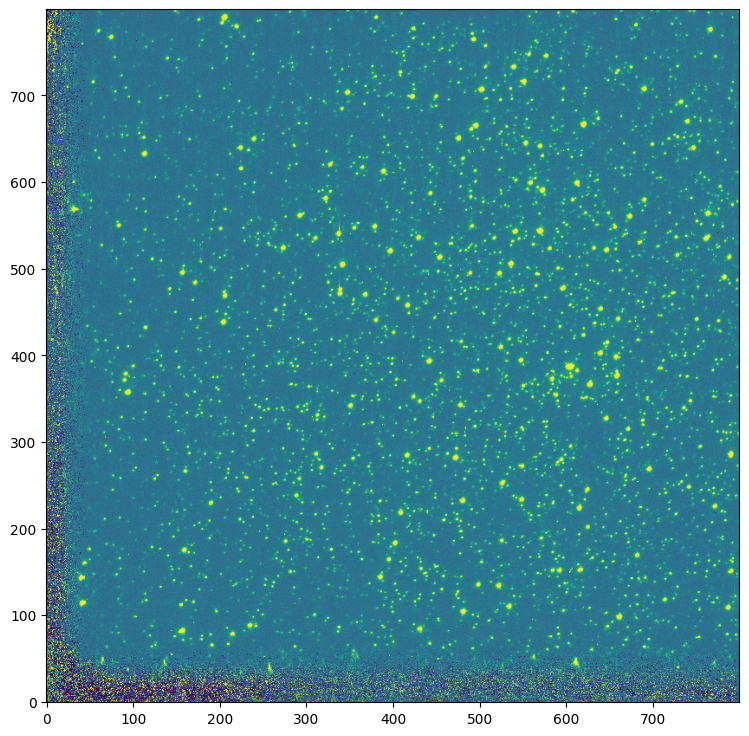

In [4]:
# Checking to see how it looks

import matplotlib.pyplot as plt
import ccd_utils as cutils

fig, ax = plt.subplots(figsize=(9, 9))
transform_img = cutils.transform_by('sqrt', median_336, pmin = 1, pmax = 99)
ax.imshow(transform_img, origin='lower', vmin=0, vmax=1)

In [26]:
## Very interesting library !pip install photutils

In [5]:
## Find Bright Sources
import scipy.ndimage as ndi

# Appyling a gaussian filter to smooth the data
smoothed336_data = ndi.gaussian_filter(median_336, sigma=0.5, mode='reflect')
smoothed555_data = ndi.gaussian_filter(median_555, sigma=0.5, mode='reflect')

# Get x,y coordinates of Peaks
def find_local_peaks(data, nsize=10):
  """
  Uses a maximum filter to find peaks in the data. From class notes:
  hst-worbook-03.ipynb.

  Parameters:
  -----------
  Input: Data [ndarray] and neighborhood size (nsize) of filter [int]

  Returns:
  -----------
  Output: Coordinates of peaks in data [ndarray]
  """
  local_max = ndi.maximum_filter(data, size = nsize)

  # turn the filter into a boolean mask where peaks are `True`
  local_max_mask = (local_max == data)

  # Not using a threshhold cause then my peak ciount would be too low
  #threshold = 2 * np.std(data)
  #threshold_mask = local_max_mask & (data> threshold)

  #print the coordinates
  coordinates = np.argwhere(local_max_mask)
  #coordinates = np.argwhere(threshold_mask)

  return coordinates

# Finding Peak Coords on Smoothed Images
smoothed336_coords = find_local_peaks(smoothed336_data)
smoothed555_coords = find_local_peaks(smoothed555_data)

# Note: 336 picks up way more peaks than 555, hopefully we can eliminate some

# Finding Peak Coords
peak336_coords = find_local_peaks(median_336)
peak555_coords = find_local_peaks(median_555)

# Note: Without smoothing, find_local_peaks find about 100 more peaks
# Note: Increasing neighborhood size decreases # of peaks found, will stick with 10



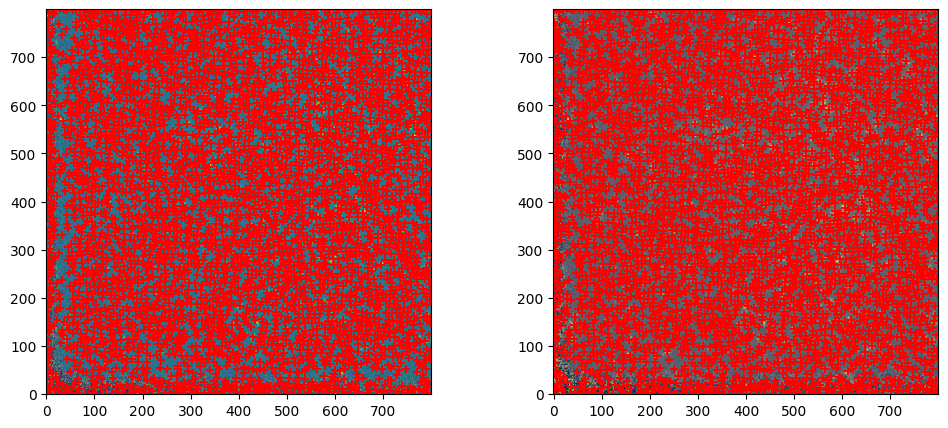

In [6]:
# Plotting to see if our peaks look good
# Normalizing images for plotting
norm_336 = cutils.transform_by('sqrt', median_336, pmin=1, pmax=99)
norm_555 = cutils.transform_by('sqrt', median_555, pmin=1, pmax=99)

# Plotting F336W
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.imshow(norm_336, origin='lower')
smooth_norm = cutils.transform_by('sqrt', smoothed336_data, pmin=1, pmax=99)
ax2.imshow(smooth_norm, origin='lower', cmap='cividis')

# Plotting the coordinates
y1, x1 = peak336_coords.T
ax1.scatter(x1, y1, marker='+', color='r')

y, x = smoothed336_coords.T
ax2.scatter(x, y, marker='+', color='r')

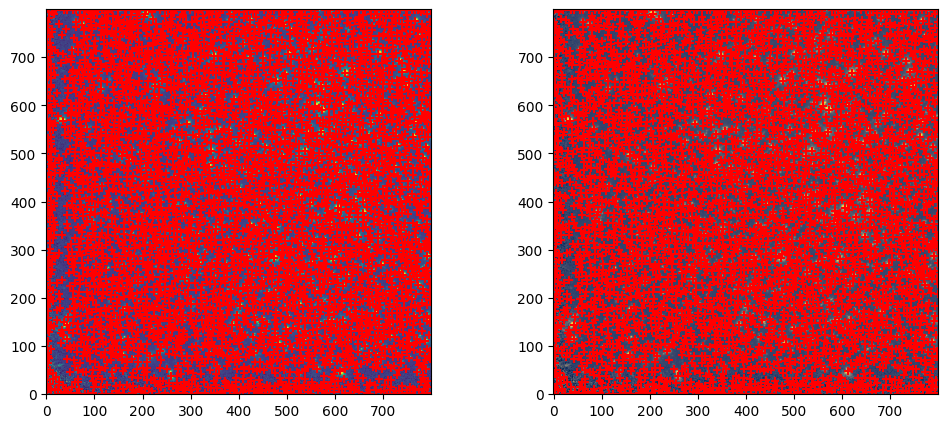

In [7]:
# Plotting for F555W
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.imshow(norm_555, origin='lower')
smooth_norm1 = cutils.transform_by('sqrt', smoothed555_data, pmin=1, pmax=99)
ax2.imshow(smooth_norm1, origin='lower', cmap='cividis')

# Plotting the coordinates
y3, x3 = peak555_coords.T
ax1.scatter(x1, y1, marker='+', color='r')

y4, x4 = smoothed555_coords.T
ax2.scatter(x, y, marker='+', color='r')

In [64]:
# Functions I'll Need for the Next Steps
from scipy.optimize import curve_fit

  # Circular Aperture function
from re import X
def circular_aperture(data, center, radius):
  """
  Extract a circular cutout from the input data.
  From class notes: hst-worbook-03-worked.ipynb.

  Parameters:
  -----------
  data : `np.ndarray`
    the input data
  center : list or tuple
    the center of the circle to extract, in y-x order
  radius : int or float
    the radius of the circle in pixels

  Returns:
  -----------
  cutout : `np.ndarray`
    a square cutout of the data
  mask : `np.ndarray`
    the circular mask used for the operation
  """

  box_size = int(np.ceil(2*radius))
  cutout = cutils.square_aperture(data, center=center, box_size = box_size)

  ys, xs = np.indices(cutout.shape) #making an index of our pixels

  # get new center of cutout
  xc = cutout.shape[1] // 2 #// integer division no remainder
  yc = cutout.shape[0] // 2

  # get pixel start position for mask
  y0 = yc - box_size // 2
  x0 = xc - box_size // 2

  # now get index coords
  x_coords = xs + x0
  y_coords = ys + y0

  # get distance from center for all these mask pixel values
  distance = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)

  # define mask as true for all values inside circle R
  mask = distance <= radius

  return cutout, mask

# Gaussian 2d Function
def gaus_2d(coords, amp, x0, y0, sigma_x, sigma_y):
  """
    A simple 2D gaussian function
    From class notes: hst-worbook-03-worked.ipynb.

    Parameters:
    -----------
    coords : list-like
      the (y, x) coordinates to evaluate
    amp : float
      the amplitude of the gaussian
    x0 : float
      the mean value in x
    y0 : float
      the mean value in y
    sigx : float
      the sigma in x
    sigy : float
      the sigma in y

    Returns:
    -----------
    res : array-like
      the evaluated function as a raveled array
  """
  y, x = coords

  gauss = amp * np.exp(
        -(((x-x0)**2/(2*sigma_x)**2) + ((y-y0)**2 / (2*sigma_y)**2))
    )

  return gauss.ravel()

  # Gaussian 2d Fit Function
def fit_gauss2d(data, p0=None):
  """
    Fit a gaussian given data and some initial parameters
    From class notes: hst-worbook-03.ipynb.

    Parameters:
    -----------
    data : np.ndarray
      the data to fit
    init_par : list or None
      the initial parameters. if None, estimate

    Returns:
    -----------
    popt : np.ndarray
      the optimized parameters of the fit
    pcov : np.ndarray
      the covariance matrix of the fit
  """

  if p0 is None:  # a nice guess for p0 so curve_fit isn't taking a long time
      a0 = data.max() - data.min()
      x0 = data.shape[1] / 2
      y0 = data.shape[0] / 2
      sigx0 = 0.5
      sigy0 = 0.5
      p0 = [a0, x0, y0, sigx0, sigy0]

  y, x = np.indices(data.shape)

  popt, pcov = curve_fit(gaus_2d, (y,x), data.ravel(), p0 = p0)

  return popt, pcov


In [65]:
## Classifying Sources as Stars

def star_finder(star_data, coords):
  """
    Function to find sources that are likely stars and add them to a catalog

    Parameters:
    -----------
    coords : list-like
      the (y, x) coordinates to evaluate
    star_data : array-like
      the image data

    Returns:
    -----------
    star_catalog : dictionary
      the final catalog of star sources with their index, locations, fluxes, and
      absolute magnitudes
  """
  from scipy.optimize import curve_fit

  # Create a Star Catalog (Dictionary)
  star_catalog = {
    'OBJECT': [],
    'XY COORD': [],
    'FLUX' : [],
    'ABS MAG': []
  }

  # Star Classification Loop:
  # - loop through coordinates of peaks
  # - take a circular cutout of source
  # - find if source is too flat or neg flux or wide
  # - if source passes, sum flux and add to dictionary

  # Index for my catalog
  star_count = 1

  # Figuring out my issue
  cutout_wrong = 0
  curvefit_wrong = 0

  for coord in coords:

    # Create Cutout around Source
    # Note: using a circular aperture to decrease source overlap

    # circular_aperture is not happy when my coordinate values are less than my radius
    # so I'll filter out those coordinates
    if coord[0] > 4 and coord[1] > 4:
      cutout, mask = circular_aperture(star_data, center = coord.T, radius = 4)
    else:
      cutout_wrong += 1
      continue #pretty sure it'll skip to new loop iteration and not do below code

    # Do Gaussian fit of Source in Cutout
    # - gives us info for flattening and width

    # Some of my coord values are crashing curve_fit so I'll reject them as well
    try:
      popt, pcov = fit_gauss2d(cutout)
    except:
      curvefit_wrong += 1
      continue

    # Sum Flux of Source in Cutout
    # Only want to sum flux within mask
    masked_data = np.ma.masked_array(data = cutout, mask = ~mask)
    source_flux = np.sum(masked_data)

    # Find Source Magnitude
    # Finding Absolute Magnitude
    source_mag = -2.5 * np.log10(abs(source_flux)) - 48.60

    # Create Star Filter
    # Flattening cutoff
    flatmax = .6
    flattening = abs(1 - min(popt[3], popt[4]) / max(popt[3], popt[4]))

    # Width cutoff
    # WFPC2 has a pixel size of 0.046"
    # (Source: Wide Field and Planetary Camera 2 Instrument Handbook for Cycle 14)
    # WFPC2's PSF function ranges from 0.02" - 0.08" depending on wavelength
    # (Source: Google Gemini AI with harvard.edu sources BUT the sources didn't work when I tried them)
    widthmax = 0.05
    width = (abs(popt[1]-popt[2]))*0.046

    if width <= widthmax and flattening <= flatmax and source_flux > 0:
      # Add source to Star Catalog
      star_catalog['OBJECT'].append(star_count)
      star_catalog['XY COORD'].append(coord)
      star_catalog['FLUX'].append(source_flux)
      star_catalog['ABS MAG'].append(source_mag)

      # Increase Star Counter
      star_count += 1

    else:
      # We don't want this source
      continue
  print(cutout_wrong)
  print(curvefit_wrong)
  return star_catalog


In [9]:
# Find Stars in Images
star_cat336 = star_finder(smoothed336_data, smoothed336_coords)

/tmp/ipython-input-1554177966.py:150: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_2d, (y,x), data.ravel(), p0 = p0)


In [10]:
star_cat555 = star_finder(smoothed555_data, smoothed555_coords)

/tmp/ipython-input-1554177966.py:150: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_2d, (y,x), data.ravel(), p0 = p0)


In [24]:
## Creating the H-R Diagram

# Combining the Catalogs
# Note: F336W found more stars than F555W

# Align by Coordinates:
# Remove Stars that don't occur in both catalogs
# So we can subtract their magnitudes for the HR Diagram

# Combining the Catalogs
# Note: F336W found more stars than F555W

# Align by Coordinates:
# Remove Stars that don't occur in both catalogs
# So we can subtract their magnitudes for the HR Diagram


# Create a new combined catalog
combined_catalog = {
   'OBJECT': [],
   'XY COORD': [],
   'F336W FLUX' : [],
   'F555W FLUX' : [],
   'F336W ABS MAG': [],
   'F555W ABS MAG': [],
   'F336W - F555W': []
}


# Index for the combined catalog
combined_count = 1


## Was helped by Gemini to create this loop below BUT
# Initially it only found direct matches (there's 43) and when I changed it
# to see if it could check one set of coords against all other coordinates,
# it took longer than five minutes and I canceled the run

# Loop through F336W Catalog
for i in range(len(star_cat336['OBJECT'])):
   #coords_336 = star_cat336['XY COORD'][i]
   flux_336 = star_cat336['FLUX'][i]
   mag_336 = star_cat336['ABS MAG'][i]


   # Check if the coords match in F555W Catalog
   found_match = False
   for j in range(len(star_cat555['OBJECT'])):

       #coords_555 = star_cat555['XY COORD'][j]

       if np.array_equal(star_cat555['XY COORD'][j], star_cat336['XY COORD']):
           # Found a match, add to the combined catalog
           combined_catalog['OBJECT'].append(combined_count)
           combined_catalog['XY COORD'].append(coords_336)
           combined_catalog['F336W FLUX'].append(flux_336)
           combined_catalog['F555W FLUX'].append(star_cat555['FLUX'][j])
           combined_catalog['F336W ABS MAG'].append(mag_336)
           combined_catalog['F555W ABS MAG'].append(star_cat555['ABS MAG'][j])
           combined_catalog['F336W - F555W'].append(mag_336 - star_cat555['ABS MAG'][j])


           combined_count += 1
           found_match = True
           break # Exit the inner loop once a match is found


   # If no match was found in F555W, this star is not included in the combined catalog
   if not found_match:
       continue




KeyboardInterrupt: 

In [23]:
len(combined_catalog['OBJECT'])

43

In [ ]:
# Creating a copy of the smaller catalog to remove
# stars without matches
# combined_catalog = star_cat336.copy()

# Removing stars without matches

#for x, y in combined_catalog['XY COORD']:
#  for a, b in star_cat336['XY COORD']:
#      if x==a and y==b:
#        continue
#      else:
#        combined_catalog['XY COORD'].remove([x,y])
#        print('removed it')

# Couldn't figure out this error:
# ValueError: The truth value of an array with more than one element is
# ambiguous. Use a.any() or a.all()


In [ ]:
# Tried to find a way to create a new combined catalog instead of
# just deleting extra data, but this bad boy took four minutes and then
# crashed google Colab after using up all the RAM. Classic

#combin = {
#    'OBJECT': [],
#    'XY COORD': [],
#    'FLUX' : [],
#    'F336W ABS MAG': [],
#    'F555W ABS MAG': [],
#    'F336W - F555W': []
#  }

#cat555_index = range(len(star_cat555['OBJECT']))
#cat336_index = range(len(star_cat336['OBJECT']))
#combin_count = 1


# Introducing: the for loop from HELL
#for i in cat555_index:
#  for j in cat336_index:
#    for x, y in star_cat555['XY COORD']:
#      for x, y in star_cat336['XY COORD']:
#        if x==x and y==y:
#          combin['OBJECT'].append(combin_count)
#          combin['XY COORD'].append([x,y])
#          combin['FLUX'].append(star_cat336['FLUX'][i])
#          combin['F336W ABS MAG'].append(star_cat336['ABS MAG'][j])
#          combin['F555W ABS MAG'].append(star_cat555['ABS MAG'][i])
#          combin['F336W - F555W'].append(star_cat336['ABS MAG'][j]-star_cat555['ABS MAG'][i])

#          combin_count += 1
#        else:
#          continue


In [66]:
# Back to the drawing board:
# We need our catalogs to be the same size to compare them
# So, I'll use the found_peak coordinates of one filter on both filters

# I'll use the whichever coordinate set is smaller
#if len(smoothed336_coords) < len(smoothed555_coords):
#coordinates = smoothed336_coords
#else:
coordinates = smoothed555_coords


In [67]:
star_cat336 = star_finder(smoothed336_data, coordinates)

/tmp/ipython-input-1515492845.py:118: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_2d, (y,x), data.ravel(), p0 = p0)


117
287


In [63]:
star_cat555 = star_finder(smoothed555_data, coordinates)

/tmp/ipython-input-4129039904.py:150: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaus_2d, (y,x), data.ravel(), p0 = p0)


117
33


In [57]:
len(star_cat336['OBJECT'])

2085

In [58]:
len(star_cat555['OBJECT'])

2659

In [ ]:
# Ok I'm losing my mind, how are they still different

# For the F336W data curve_fit failed to find the covariance for peaks 287 times
# For the F555W data curve_fit failed to find the covariance for peaks 33 times
# I get similar discrepancies even if I normalize the data. Stupid pos curve_fit

# maybe it's variable names? having my functions all in one big function could fuck it up
# nope, changed that and that didn't work

In [70]:
# Try from Andrew's worked notebook
# code here
from scipy.optimize import curve_fit

# demonstrator's code
def gaussian_2d(coords, amp, x0, y0, sigx, sigy):
    """
    A simple 2D gaussian function

    Parameters:
    -----------
    coords : list-like
        the (y, x) coordinates to evaluate
    amp : float
        the amplitude of the gaussian
    x0 : float
        the mean value in x
    y0 : float
        the mean value in y
    sigx : float
        the sigma in x
    sigy : float
        the sigma in y

    Returns:
    -----------
    res : array-like
        the evaluated function as a raveled array
    """

    y, x = coords
    g = amp * np.exp(
        -(((x - x0) ** 2) / (2 * sigx**2) + ((y - y0) ** 2) / (2 * sigy**2))
    )
    return g


def fit_gauss_2d(data, init_par=None):
    """
    Fit a gaussian given data and some initial parameters

    Parameters:
    -----------
    data : np.ndarray
        the data to fit
    init_par : list or None
        the initial parameters. if None, estimate

    Returns:
    -----------
    popt : np.ndarray
        the optimized parameters of the fit
    pcov : np.ndarray
        the covariance matrix of the fit
    """

    if init_par is None:
        amp = data.max() - data.min()
        x0 = data.shape[1] / 2
        y0 = data.shape[0] / 2
        sigx, sigy = estimate_gaussian_sigma(data)
        init_par = [amp, x0, y0, sigx, sigy]

    y, x = np.indices(data.shape)

    popt, pcov = sp.optimize.curve_fit(
        gaussian_2d,
        (y, x),
        data.ravel(),
        p0=init_par
    )

    return popt, pcov



In [80]:
## Classifying Sources as Stars

def star_finder2(star_data, coords):
  """
    Function to find sources that are likely stars and add them to a catalog

    Parameters:
    -----------
    coords : list-like
      the (y, x) coordinates to evaluate
    star_data : array-like
      the image data

    Returns:
    -----------
    star_catalog : dictionary
      the final catalog of star sources with their index, locations, fluxes, and
      absolute magnitudes
  """
  from scipy.optimize import curve_fit

  # Create a Star Catalog (Dictionary)
  star_catalog = {
    'OBJECT': [],
    'XY COORD': [],
    'FLUX' : [],
    'ABS MAG': []
  }

  # Star Classification Loop:
  # - loop through coordinates of peaks
  # - take a circular cutout of source
  # - find if source is too flat or neg flux or wide
  # - if source passes, sum flux and add to dictionary

  # Index for my catalog
  star_count = 1

  # Figuring out my issue
  cutout_wrong = 0
  curvefit_wrong = 0

  for coord in coords:

    # Create Cutout around Source
    # Note: using a circular aperture to decrease source overlap

    # circular_aperture is not happy when my coordinate values are less than my radius
    # so I'll filter out those coordinates
    if coord[0] > 4 and coord[1] > 4:
      cutout, mask = circular_aperture(star_data, center = coord.T, radius = 5)
    else:
      cutout_wrong += 1
      continue #pretty sure it'll skip to new loop iteration and not do below code

    # Do Gaussian fit of Source in Cutout
    # - gives us info for flattening and width

    # Some of my coord values are crashing curve_fit so I'll reject them as well
    try:
      popt, pcov = fit_gauss_2d(cutout)
    except:
      curvefit_wrong += 1
      continue

    # Sum Flux of Source in Cutout
    # Only want to sum flux within mask
    masked_data = np.ma.masked_array(data = cutout, mask = ~mask)
    source_flux = np.sum(masked_data)

    # Find Source Magnitude
    # Finding Absolute Magnitude
    source_mag = -2.5 * np.log10(abs(source_flux)) - 48.60

    # Create Star Filter
    # Flattening cutoff
    flatmax = .6
    flattening = abs(1 - min(popt[3], popt[4]) / max(popt[3], popt[4]))

    # Width cutoff
    # WFPC2 has a pixel size of 0.046"
    # (Source: Wide Field and Planetary Camera 2 Instrument Handbook for Cycle 14)
    # WFPC2's PSF function ranges from 0.02" - 0.08" depending on wavelength
    # (Source: Google Gemini AI with harvard.edu sources BUT the sources didn't work when I tried them)
    widthmax = 0.05
    width = (abs(popt[1]-popt[2]))*0.046

    if width <= widthmax and flattening <= flatmax and source_flux > 0:
      # Add source to Star Catalog
      star_catalog['OBJECT'].append(star_count)
      star_catalog['XY COORD'].append(coord)
      star_catalog['FLUX'].append(source_flux)
      star_catalog['ABS MAG'].append(source_mag)

      # Increase Star Counter
      star_count += 1

    else:
      # We don't want this source
      continue
  print(cutout_wrong)
  print(curvefit_wrong)
  return star_catalog


In [83]:
star_cat336 = star_finder(norm_336, coordinates)

117
734


In [76]:
star_cat555 = star_finder(norm_555, coordinates)

117
303


In [81]:
star_cat336 = star_finder2(smoothed336_data, coordinates)

117
3996


In [82]:
star_cat555 = star_finder2(smoothed555_data, coordinates)

117
3996


In [ ]:
# for some reason Andrew's gaussian curve_fit code doesn't work AT ALL WHAT AM I DOING WRONG
# Why is it passing try so quickly now? I'm not even getting a covariance optimisation warning

In [79]:
len(star_cat336['OBJECT'])

0

In [ ]:
# omg could it be because it's doing the math in flux? no, it worked for previous flux data in
# the hst notebooks
# what have I done wroonnngg
# is it my smoothed data shooting me in the foor?